In [32]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import opening, closing, disk

### Load Sharpened Images with their Masks

In [33]:
# images
left_ims = glob.glob('trees/sharpened/sharpened_left_*.png')
right_ims = glob.glob('trees/sharpened/sharpened_right_*.png')

# masks
left_masks = glob.glob('trees/matlab_masks/mask_left_*.png')
right_masks = glob.glob('trees/matlab_masks/mask_right_*.png')

assert(len(left_ims) == len(right_ims))
assert(len(left_masks) == len(right_masks))

### Create Disparity Maps and Mask Them

In [ ]:
# ------------------------------------- #
# SETUP
# ------------------------------------- #

# read camera data
data = cv2.FileStorage('stereo_params_v7.yml', cv2.FILE_STORAGE_READ)
keys = ["K1", "K2", "D1", "D2", "R1", "R2", "P1", "P2", "T"]
[K1, K2, D1, D2, R1, R2, P1, P2, T] = [data.getNode(key).mat() for key in keys]

'''
We know that

        |f  0   cx1  0|
P1 =    |0  f   cy   0|
        |0  f   1    0|

and 

        |f  0   cx2  Tx*f|
P2 =    |0  f   cy   0   |
        |0  f   1    0   |

and in our case, cx1 = cx2 = cx
'''

f = K1[0,0]
Tx = T[0,0]
P1 = np.hstack((K1, np.array([[0],[0],[0]])))
P2 = np.hstack((K2, np.array([[Tx*f],[0],[0]])))


# ------------------------------------- #
# STEREO RECTIFICATION
# ------------------------------------- #
i = 1
for file_L, file_R, mask_file_L in zip(left_ims, right_ims, left_masks):

        imgL = cv2.imread(file_L, 0)
        imgR = cv2.imread(file_R, 0)
        maskL = cv2.imread(mask_file_L, 0)

        h1, w1 = imgL.shape
        h2, w2 = imgR.shape


        # rectify images using initUndistortRectifyMap
        xmap1, ymap1 = cv2.initUndistortRectifyMap(K1, D1, R1, P1, (w1,h1), cv2.CV_32FC1)
        xmap2, ymap2 = cv2.initUndistortRectifyMap(K2, D2, R2, P2, (w1,h1), cv2.CV_32FC1)

        imgL_rectified = cv2.remap(imgL, xmap1, ymap1, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
        maskL_rectified = cv2.remap(maskL, xmap1, ymap1, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
        imgR_rectified = cv2.remap(imgR, xmap2, ymap2, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
        remap_combined = np.hstack((imgL_rectified, imgR_rectified))

        # Plot the Rectified Images
        # fig, axes = plt.subplots(figsize=(12,3.5))
        # axes.imshow(remap_combined, 'gray')
        # axes.hlines((200, 300, 400, 500, 600), xmin=0, xmax=2559)
        # plt.suptitle("Rectified Images")
        # plt.show()


        # -------------------------------- #
        # COMPUTE DISPARITY MAP
        # -------------------------------- #

        # Matched blocked size
        block_size = 11
        min_disp = -128
        max_disp = 128

        num_disp = max_disp - min_disp
        uniquenessRatio = 5
        speckleWindowSize = 200
        speckleRange = 2
        disp12MaxDiff = 0

        stereo = cv2.StereoSGBM_create(
        minDisparity=min_disp,
        numDisparities=num_disp,
        blockSize=block_size,
        uniquenessRatio=uniquenessRatio,
        speckleWindowSize=speckleWindowSize,
        speckleRange=speckleRange,
        disp12MaxDiff=disp12MaxDiff,
        P1=8 * block_size * block_size,
        P2=32 * block_size * block_size
        )

        disparity_SGBM = stereo.compute(imgL_rectified, imgR_rectified)
        disparity_SGBM = cv2.normalize(disparity_SGBM,
                                disparity_SGBM,
                                beta=0,
                                alpha=255,
                                norm_type=cv2.NORM_MINMAX)
        disparity_SGBM = np.uint8(disparity_SGBM)
        # cv2.imwrite('disparitySGBM.png', disparity_SGBM)


        # -------------------------------- #
        # FILTER DISPARITY MAP
        # -------------------------------- #
        right_matcher = cv2.ximgproc.createRightMatcher(stereo)
        # filter parameters
        lmbda = 8000
        sigma = 1.5
        visual_multiplier = 6

        wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=stereo)
        wls_filter.setLambda(lmbda)
        wls_filter.setSigmaColor(sigma)
        dispL = stereo.compute(imgL_rectified, imgR_rectified)

        # erode and dilate dispL
        selem = disk(8)
        dispL = closing(opening(dispL, selem), selem)
        dispR = right_matcher.compute(imgR_rectified, imgL_rectified)

        # erode and dilate dispR
        dispR = closing(opening(dispR, selem), selem)
        dispL = np.int16(dispL)
        dispR = np.int16(dispR)

        filteredImg = wls_filter.filter(dispL, imgL_rectified, None, dispR)

        # Normalize the values to the range 0-255 for a grayscale image
        filteredImg = cv2.normalize(filteredImg,
                                filteredImg,
                                beta=0,
                                alpha=255,
                                norm_type=cv2.NORM_MINMAX)
        filteredImg = np.uint8(filteredImg)
        # cv2.imwrite('filteredSGBM.png', filteredImg)

        # Plot original images and depth maps side by side
        plt.figure(figsize=(20,10))
        plt.subplot(221), plt.imshow(imgL, 'gray'), plt.title('Left Original')
        plt.subplot(222), plt.imshow(imgR, 'gray'), plt.title('Right Original')
        plt.subplot(223), plt.imshow(disparity_SGBM, 'gray'), plt.title('Disparity (Raw)')
        plt.subplot(224), plt.imshow(filteredImg, 'gray'), plt.title('Disparity (Filtered)')
        plt.show()

        # save disparity maps
        cv2.imwrite('trees/filtered_disparity_maps/filtered_disparity_' + str(i) + '.png', filteredImg)
        filteredImg[maskL_rectified == 0] = 0
        cv2.imwrite('trees/masked_disparity_maps/masked_disparity_' + str(i) + '.png', filteredImg)
        i += 1


### Save Disparity Values for Regression Line

In [ ]:
left_ims = glob.glob('area4/left_*.png')
right_ims = glob.glob('area4/right_*.png')

print(left_ims)

In [ ]:
sorted(['1','2','3','10','11','13','12','23','35','4','5','6','7'])

In [ ]:
# ------------------------------------- #
# SETUP
# ------------------------------------- #

# read camera data
data = cv2.FileStorage('stereo_params.yml', cv2.FILE_STORAGE_READ)
keys = ["K1", "K2", "D1", "D2", "R1", "R2", "P1", "P2", "T"]
[K1, K2, D1, D2, R1, R2, P1, P2, T] = [data.getNode(key).mat() for key in keys]

'''
We know that

        |f  0   cx1  0|
P1 =    |0  f   cy   0|
        |0  f   1    0|

and 

        |f  0   cx2  Tx*f|
P2 =    |0  f   cy   0   |
        |0  f   1    0   |

and in our case, cx1 = cx2 = cx
'''

f = K1[0,0]
Tx = T[0,0]
P1 = np.hstack((K1, np.array([[0],[0],[0]])))
P2 = np.hstack((K2, np.array([[Tx*f],[0],[0]])))


# ------------------------------------- #
# LOAD IMAGES
# ------------------------------------- #
left_ims = glob.glob('area4/left_*.png')
right_ims = glob.glob('area4/right_*.png')

# ------------------------------------- #
# STEREO RECTIFICATION
# ------------------------------------- #
disparities = []

for file_L, file_R in zip(left_ims, right_ims):
        
        imgL = cv2.imread(file_L, 0)
        imgR = cv2.imread(file_R, 0)

        h1, w1 = imgL.shape

        # rectify images using initUndistortRectifyMap
        xmap1, ymap1 = cv2.initUndistortRectifyMap(K1, D1, R1, P1, (w1,h1), cv2.CV_32FC1)
        xmap2, ymap2 = cv2.initUndistortRectifyMap(K2, D2, R2, P2, (w1,h1), cv2.CV_32FC1)

        imgL_rectified = cv2.remap(imgL, xmap1, ymap1, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
        imgR_rectified = cv2.remap(imgR, xmap2, ymap2, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
        remap_combined = np.concatenate((imgL_rectified, imgR_rectified), axis=1)

        # -------------------------------- #
        # COMPUTE DISPARITY MAP
        # -------------------------------- #

        # Matched blocked size
        block_size = 11
        min_disp = -128
        max_disp = 128

        num_disp = max_disp - min_disp
        uniquenessRatio = 5
        speckleWindowSize = 200
        speckleRange = 2
        disp12MaxDiff = 0

        stereo = cv2.StereoSGBM_create(
                        minDisparity=min_disp,
                        numDisparities=num_disp,
                        blockSize=block_size,
                        uniquenessRatio=uniquenessRatio,
                        speckleWindowSize=speckleWindowSize,
                        speckleRange=speckleRange,
                        disp12MaxDiff=disp12MaxDiff,
                        P1=8 * block_size * block_size,
                        P2=32 * block_size * block_size
                        )

        disparity_SGBM = stereo.compute(imgL_rectified, imgR_rectified)
        disparity_SGBM = cv2.normalize(disparity_SGBM,
                                disparity_SGBM,
                                beta=0,
                                alpha=255,
                                norm_type=cv2.NORM_MINMAX)
        disparity_SGBM = np.uint8(disparity_SGBM)
        # cv2.imwrite('disparitySGBM.png', disparity_SGBM)


        # -------------------------------- #
        # FILTER DISPARITY MAP
        # -------------------------------- #
        right_matcher = cv2.ximgproc.createRightMatcher(stereo)
        # filter parameters
        lmbda = 80000
        sigma = 1.5
        visual_multiplier = 6

        wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=stereo)
        wls_filter.setLambda(lmbda)
        wls_filter.setSigmaColor(sigma)

        dispL = stereo.compute(imgL_rectified, imgR_rectified)
        dispR = right_matcher.compute(imgR_rectified, imgL_rectified)

        dispL = np.int16(dispL)
        dispR = np.int16(dispR)

        filteredImg = wls_filter.filter(dispL, imgL_rectified, None, dispR)
        # Normalize the values to the range 0-255 for a grayscale image
        filteredImg = cv2.normalize(filteredImg,
                                filteredImg,
                                beta=0,
                                alpha=255,
                                norm_type=cv2.NORM_MINMAX)
        filteredImg = np.uint8(filteredImg)
        disparities.append(filteredImg[359, 748])

print(disparities)

In [ ]:
d = [186, 162, 145, 122, 106, 99, 92, 86, 79, 73, 72, 65, 62, 65, 57, 55, 52, 
    53, 51, 49, 49, 45, 45, 45, 44, 44, 43, 45, 45, 43, 43, 43, 42, 117, 42, 40, 40, 94, 39]

len(d)

### Regression Line (Short: <15m)

In [ ]:
dist = np.linspace(2.0, 11.6, 33)
disp = np.array([186, 207, 178, 129, 124, 113, 104, 168, 94, 88, 160, 97, 78, 73, 74, 
                 77, 66, 66, 62, 60, 108, 56, 94, 53, 51, 50, 49, 46, 45, 80, 44, 93, 41])

len(disp) == len(dist)

### Regression Line 2 (Short: <15m)

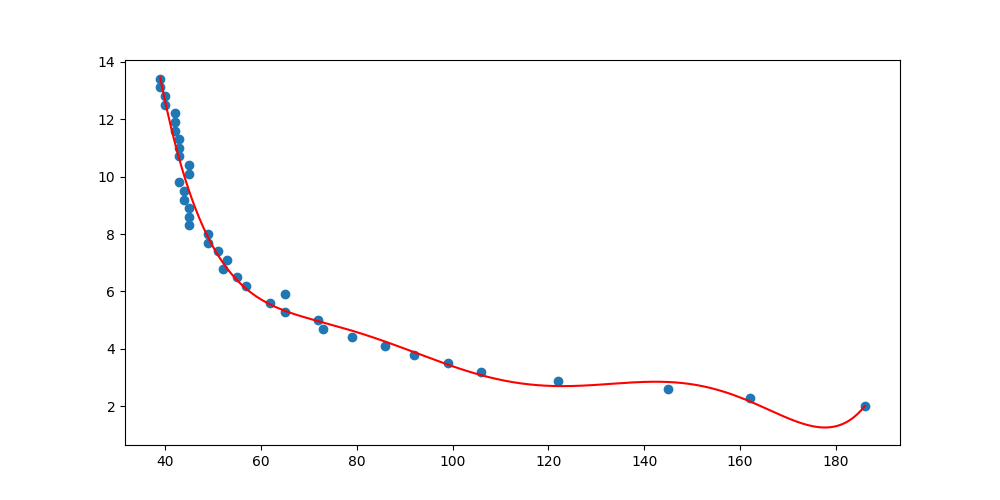

In [94]:
dist1 = np.linspace(2.0, 13.4, 39)
disp1 = np.array([186, 162, 145, 122, 106, 99, 92, 86, 79, 73, 72, 65, 62, 65, 57, 55, 52, 
    53, 51, 49, 49, 45, 45, 45, 44, 44, 43, 45, 45, 43, 43, 43, 42, 42, 42, 40, 40, 39, 39])

model = np.poly1d(np.polyfit(disp1, dist1, 6))
points = np.linspace(39, 186, 600)

plt.figure(figsize=(10, 5))
plt.plot(points, model(points), color='r')
plt.scatter(disp1, dist1)
plt.show()

In [52]:
print(model)

 
7.7


### Regression Line 3 (Long: Up to 35m)

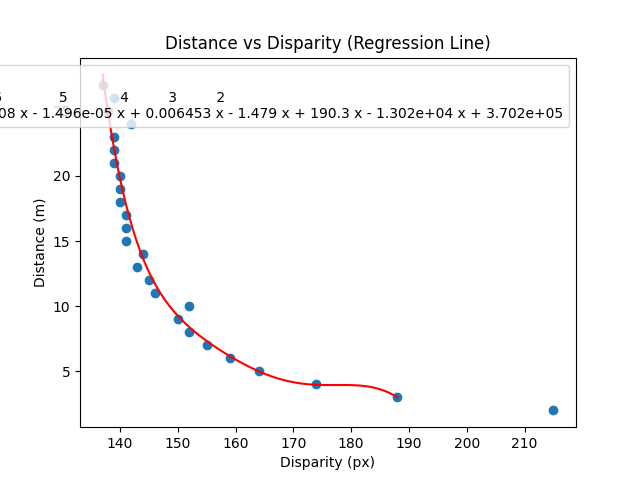

In [36]:
dist = np.arange(2, 28, 1)
disp = np.array([215, 188, 174, 164, 159, 155, 152, 150, 152, 146, 
                145, 143, 144, 141, 141, 141, 140, 140, 140, 139, 139, 139, 142, 138, 139, 137])

# x = np.arange(137, 216, 1)
# y = np.exp(23.08) * (1.2442 ** -x) * (1.006 ** (x ** 2))

# polynomial fit
model = np.poly1d(np.polyfit(disp, dist, 6))
polyline = np.linspace(137, 188, 400)

# exponential fit
# fit = np.polyfit(disp, np.log(dist), 2)
# print(fit)

plt.figure()
plt.scatter(disp, dist, label='Scatter')
# plt.plot(x, y)
plt.plot(polyline, model(polyline), color='red', label=str(model))
plt.xlabel('Disparity (px)')
plt.ylabel('Distance (m)')
plt.title('Distance vs Disparity (Regression Line)')
plt.legend()
plt.show()


### SciPy Curve Fitting

[2.67610726 1.35066979 0.49336112]
[2.67610726 1.35066979 0.49336112]


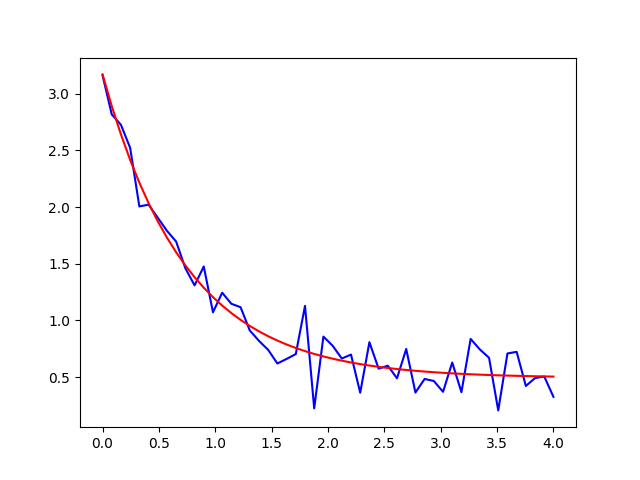

In [95]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

xdata = np.linspace(0, 4, 50)
y = func(xdata, 2.5, 1.3, 0.5)
rng = np.random.default_rng()
noise = 0.2 * rng.normal(size=xdata.size)
ydata = y + noise

popt, pcov = curve_fit(func, xdata, ydata)
print(popt)
print(popt)

plt.figure()
plt.plot(xdata, ydata, 'b-', label='data')
plt.plot(xdata, func(xdata, *popt), 'r-', label='fit')
plt.show()

### Top, base, Left and Right Extreme Pixels

In [ ]:
# load segmented depth map
img = cv2.imread('trees/masked_disparity_maps/masked_disparity_1.png', 0)

rows, cols = img.nonzero()
coords = list(zip(rows, cols))
base = [(x,y) for x,y in coords if x == rows.max()][0]
top = [(x,y) for x,y in coords if x == rows.min()][0]
left = [(x,y) for x,y in coords if y == cols.min()][0]
right = [(x,y) for x,y in coords if y == cols.max()][0]

In [ ]:
%matplotlib widget

plt.figure(figsize=(8,3))
plt.imshow(img, 'gray')
plt.hlines(base[0], 0, 1280)
plt.vlines([left[1], right[1]], 0, 720)
plt.show()